c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


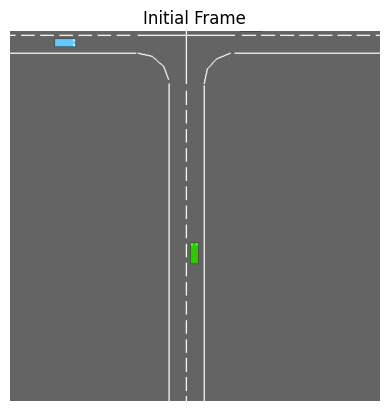

In [1]:
# Import libraries and make sure intersection-env is installed properly
import highway_env
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
# pprint([env for env in gym.envs.registry.keys() if "intersection" in env])

# Create the environment with visual rendering
env = gym.make("intersection-v0", render_mode="rgb_array")
obs, info = env.reset()

# Render and show the first frame
frame = env.render()
plt.imshow(frame)
plt.axis('off')
plt.title("Initial Frame")
plt.show()

env.close()

In [2]:
from pprint import pprint

# print the environment information
print("Environment Information:")
pprint(env.unwrapped.config)
print("Action Space:", env.action_space)

Environment Information:
{'action': {'lateral': False,
            'longitudinal': True,
            'target_speeds': [0, 4.5, 9],
            'type': 'DiscreteMetaAction'},
 'arrived_reward': 1,
 'centering_position': [0.5, 0.6],
 'collision_reward': -5,
 'controlled_vehicles': 1,
 'destination': 'o1',
 'duration': 13,
 'high_speed_reward': 1,
 'initial_vehicle_count': 10,
 'manual_control': False,
 'normalize_reward': False,
 'observation': {'absolute': True,
                 'features': ['presence',
                              'x',
                              'y',
                              'vx',
                              'vy',
                              'cos_h',
                              'sin_h'],
                 'features_range': {'vx': [-20, 20],
                                    'vy': [-20, 20],
                                    'x': [-100, 100],
                                    'y': [-100, 100]},
                 'flatten': False,
                 'obs

In [3]:
import tensorboard
print(tensorboard.__version__)

2.17.1


In [4]:
import torch
print(torch.cuda.is_available())   # Should be True
print(torch.cuda.get_device_name(0))  # Should show GPU name


True
NVIDIA GeForce RTX 3080


In [5]:
import gymnasium as gym
from stable_baselines3.common.monitor import Monitor
# === Create wrapped evaluation env ===
def make_env(render_mode=None):
    def _init():
        env = gym.make("intersection-v0", render_mode=render_mode)
        return Monitor(env)
    return _init

In [6]:
import os
import json
import optuna
import torch
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback
from optuna.pruners import MedianPruner

# === Configuration ===
SAVE_DIR = "../trained_models/intersection/PPO/"
os.makedirs(SAVE_DIR, exist_ok=True)

COARSE_PARAMS_PATH = os.path.join(SAVE_DIR, "PPO_best_coarse_params.json")

# Track best rewards per phase
best_rewards = {"coarse": -float("inf"), "fine": -float("inf")}

# === Optuna Callback for pruning ===
class OptunaCallback(BaseCallback):
    def __init__(self, trial, eval_freq=2000, n_eval_episodes=3, verbose=0):
        super().__init__(verbose)
        self.trial = trial
        self.eval_freq = eval_freq
        self.n_eval_episodes = n_eval_episodes

    def _on_step(self):
        if self.n_calls % self.eval_freq == 0:
            reward, _ = evaluate_policy(self.model, self.training_env, n_eval_episodes=self.n_eval_episodes, deterministic=True)
            self.trial.report(reward, self.n_calls)
            if self.trial.should_prune():
                raise optuna.exceptions.TrialPruned()
        return True

# === Objective Function ===
def objective(trial, phase, coarse_params=None):
    global best_rewards

    # Coarse tuning: explore main params
    if phase == "coarse":
        learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
        gamma = trial.suggest_float("gamma", 0.85, 0.999)
        net_arch = trial.suggest_categorical("net_arch", [[64, 64], [128, 128], [256, 256]])
        config = {
            "learning_rate": learning_rate,
            "gamma": gamma,
            "net_arch": net_arch,
        }

    # Fine tuning: fix coarse, tune others
    elif phase == "fine":
        assert coarse_params is not None, "Missing coarse parameters for fine tuning"
        config = {
            **coarse_params,
            "entropy_coef": trial.suggest_float("entropy_coef", 1e-4, 0.05),
            "clip_range": trial.suggest_float("clip_range", 0.1, 0.3),
            "gae_lambda": trial.suggest_float("gae_lambda", 0.8, 0.99),
            "vf_coef": trial.suggest_float("vf_coef", 0.3, 0.9),
            "max_grad_norm": trial.suggest_float("max_grad_norm", 0.3, 1.0),
            "n_steps": trial.suggest_categorical("n_steps", [64, 128, 256]),
            "batch_size": trial.suggest_categorical("batch_size", [32, 64, 128])
        }

    # Create env and model
    env = make_vec_env(make_env(), n_envs=1)
    model = PPO(
        "MlpPolicy",
        env,
        learning_rate=config["learning_rate"],
        gamma=config["gamma"],
        policy_kwargs={"net_arch": config["net_arch"]},
        ent_coef=config.get("entropy_coef", 0.01),
        clip_range=config.get("clip_range", 0.2),
        gae_lambda=config.get("gae_lambda", 0.95),
        vf_coef=config.get("vf_coef", 0.5),
        max_grad_norm=config.get("max_grad_norm", 0.5),
        n_steps=config.get("n_steps", 128),
        batch_size=config.get("batch_size", 64),
        verbose=0,
        tensorboard_log=f"../tensorboard_logs/intersection/PPO_phase_{phase}",
        device="cpu"
    )

    print(f"Starting training for trial {trial.number}...")
    print(f"Phase: {phase}, Config: {config}")
    model.learn(total_timesteps=10_000, callback=OptunaCallback(trial))

    mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=5, deterministic=True)
    trial.set_user_attr("mean_reward", mean_reward)

    # Save best model immediately when improved
    if mean_reward > best_rewards[phase]:
        best_rewards[phase] = mean_reward
        model.save(os.path.join(SAVE_DIR, f"PPO_best_{phase}.zip"))
        print(f"Saved new best {phase} model (trial {trial.number})")
        if phase == "coarse":
            with open(COARSE_PARAMS_PATH, "w") as f:
                json.dump(config, f, indent=2)
            print(f"✅ Coarse tuning updated. Best trial {trial.number} saved.")

    return mean_reward

# === PHASE 1: Coarse Tuning ===
def run_coarse_phase():
    print("Starting COARSE tuning...")
    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(seed=42),
        pruner=MedianPruner(n_startup_trials=3, n_warmup_steps=1)
    )
    study.optimize(lambda trial: objective(trial, phase="coarse"), n_trials=8)

# === PHASE 2: Fine Tuning ===
def run_fine_phase():
    if not os.path.exists(COARSE_PARAMS_PATH):
        raise FileNotFoundError("Missing coarse phase results. Run coarse phase first.")
    with open(COARSE_PARAMS_PATH, "r") as f:
        coarse_params = json.load(f)

    print("Starting FINE tuning with coarse-fixed params...")
    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(seed=123),
        pruner=MedianPruner(n_startup_trials=3, n_warmup_steps=1)
    )
    study.optimize(lambda trial: objective(trial, phase="fine", coarse_params=coarse_params), n_trials=8)
    print("✅ Fine tuning complete.")

# === MAIN ===
run_coarse = False
run_fine = True

if run_coarse:
    run_coarse_phase()

if run_fine:
    run_fine_phase()


[I 2025-07-31 01:47:45,859] A new study created in memory with name: no-name-ffb84a47-eb70-4abf-b4c0-6e2f4a13c45d


Starting FINE tuning with coarse-fixed params...


c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


Starting training for trial 0...
Phase: fine, Config: {'learning_rate': 1.0994335574766187e-05, 'gamma': 0.9945165679721372, 'net_arch': [64, 64], 'entropy_coef': 0.0348538123613333, 'clip_range': 0.1572278669900759, 'gae_lambda': 0.8431017761771986, 'vf_coef': 0.6307888614497348, 'max_grad_norm': 0.8036282788498941, 'n_steps': 128, 'batch_size': 32}


[I 2025-07-31 01:55:34,585] Trial 0 finished with value: 1.6 and parameters: {'entropy_coef': 0.0348538123613333, 'clip_range': 0.1572278669900759, 'gae_lambda': 0.8431017761771986, 'vf_coef': 0.6307888614497348, 'max_grad_norm': 0.8036282788498941, 'n_steps': 128, 'batch_size': 32}. Best is trial 0 with value: 1.6.


Saved new best fine model (trial 0)
Starting training for trial 1...
Phase: fine, Config: {'learning_rate': 1.0994335574766187e-05, 'gamma': 0.9945165679721372, 'net_arch': [64, 64], 'entropy_coef': 0.03647958039846368, 'clip_range': 0.18771444893592487, 'gae_lambda': 0.8113388003558181, 'vf_coef': 0.5388265531982589, 'max_grad_norm': 0.8165967840124249, 'n_steps': 256, 'batch_size': 128}


c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
[I 2025-07-31 02:03:22,337] Trial 1 finished with value: 3.4 and parameters: {'entropy_coef': 0.03647958039846368, 'clip_range': 0.18771444893592487, 'gae_lambda': 0.8113388003558181, 'vf_coef': 0.5388265531982589, 'max_grad_norm': 0.8165967840124249, 'n_steps': 256, 'batch_size': 128}. Best is trial 1 with value: 3.4.


Saved new best fine model (trial 1)
Starting training for trial 2...
Phase: fine, Config: {'learning_rate': 1.0994335574766187e-05, 'gamma': 0.9945165679721372, 'net_arch': [64, 64], 'entropy_coef': 0.0362503207105457, 'clip_range': 0.22220470213551657, 'gae_lambda': 0.9372642426883421, 'vf_coef': 0.49377534831190695, 'max_grad_norm': 0.5532520589356198, 'n_steps': 256, 'batch_size': 64}


c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
[I 2025-07-31 02:11:06,132] Trial 2 finished with value: 1.8240182 and parameters: {'entropy_coef': 0.0362503207105457, 'clip_range': 0.22220470213551657, 'gae_lambda': 0.9372642426883421, 'vf_coef': 0.49377534831190695, 'max_grad_norm': 0.5532520589356198, 'n_steps': 256, 'batch_size': 64}. Best is trial 1 with value: 3.4.
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning: You have specified a mini-batch size of 128, but because the `RolloutBuffer` is of size `n_steps * n_

Starting training for trial 3...
Phase: fine, Config: {'learning_rate': 1.0994335574766187e-05, 'gamma': 0.9945165679721372, 'net_arch': [64, 64], 'entropy_coef': 0.02473488637275028, 'clip_range': 0.18516605805916558, 'gae_lambda': 0.8593296323647684, 'vf_coef': 0.5558107841776849, 'max_grad_norm': 0.9253724141819943, 'n_steps': 64, 'batch_size': 128}


[I 2025-07-31 02:15:39,197] Trial 3 pruned. 
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


Starting training for trial 4...
Phase: fine, Config: {'learning_rate': 1.0994335574766187e-05, 'gamma': 0.9945165679721372, 'net_arch': [64, 64], 'entropy_coef': 0.04332882697837996, 'clip_range': 0.15009107307930133, 'gae_lambda': 0.8917765102099139, 'vf_coef': 0.891335871366423, 'max_grad_norm': 0.6636395834818665, 'n_steps': 256, 'batch_size': 32}


[I 2025-07-31 02:23:28,527] Trial 4 finished with value: 3.8 and parameters: {'entropy_coef': 0.04332882697837996, 'clip_range': 0.15009107307930133, 'gae_lambda': 0.8917765102099139, 'vf_coef': 0.891335871366423, 'max_grad_norm': 0.6636395834818665, 'n_steps': 256, 'batch_size': 32}. Best is trial 4 with value: 3.8.


Saved new best fine model (trial 4)
Starting training for trial 5...
Phase: fine, Config: {'learning_rate': 1.0994335574766187e-05, 'gamma': 0.9945165679721372, 'net_arch': [64, 64], 'entropy_coef': 0.015275627372456486, 'clip_range': 0.18340444220494032, 'gae_lambda': 0.9294471455006313, 'vf_coef': 0.8252741050771051, 'max_grad_norm': 0.6572956362346077, 'n_steps': 64, 'batch_size': 64}


c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
[I 2025-07-31 02:28:00,685] Trial 5 pruned. 
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


Starting training for trial 6...
Phase: fine, Config: {'learning_rate': 1.0994335574766187e-05, 'gamma': 0.9945165679721372, 'net_arch': [64, 64], 'entropy_coef': 0.03820777378802258, 'clip_range': 0.1487332749073748, 'gae_lambda': 0.8369023625099665, 'vf_coef': 0.6434741744948839, 'max_grad_norm': 0.36699876162867096, 'n_steps': 64, 'batch_size': 64}


[I 2025-07-31 02:29:30,756] Trial 6 pruned. 
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


Starting training for trial 7...
Phase: fine, Config: {'learning_rate': 1.0994335574766187e-05, 'gamma': 0.9945165679721372, 'net_arch': [64, 64], 'entropy_coef': 0.008032086242821665, 'clip_range': 0.13061410302495463, 'gae_lambda': 0.9321506104664731, 'vf_coef': 0.4912598558291258, 'max_grad_norm': 0.7843792068722737, 'n_steps': 256, 'batch_size': 32}


[I 2025-07-31 02:34:03,898] Trial 7 pruned. 


✅ Fine tuning complete.


In [7]:
import os
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
import gymnasium as gym

SAVE_DIR = "../trained_models/intersection/PPO/"
# === Load trained Optuna model ===
model_path = os.path.join(SAVE_DIR, "PPO_best_fine.zip")
model = PPO.load(model_path)

# === Environment for continued training ===
train_env = make_vec_env(make_env(), n_envs=1)

# === Rebind environment in case original wasn't saved in model ===
model.set_env(train_env)

# === Training configuration ===
total_timesteps = 40000
save_interval = 10000
timesteps_run = 0

cp_log_dir = f"../checkpoints/intersection/PPO_optuna"
os.makedirs(cp_log_dir, exist_ok=True)

while timesteps_run < total_timesteps:
    model.learn(
        total_timesteps=save_interval,
        reset_num_timesteps=False,
        tb_log_name="intersection_PPO_optuna",
        log_interval=1,
    )
    timesteps_run += save_interval
    model.save(f"{cp_log_dir}/{timesteps_run}")
    print(f"✅ Saved checkpoint at {timesteps_run} timesteps")

# === Save final model ===
final_model_path = os.path.join(SAVE_DIR, "PPO_trained_tuned.zip")
model.save(final_model_path)
print(f"✅ Final model saved at {final_model_path}")


c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


✅ Saved checkpoint at 10000 timesteps
✅ Saved checkpoint at 20000 timesteps
✅ Saved checkpoint at 30000 timesteps
✅ Saved checkpoint at 40000 timesteps
✅ Final model saved at ../trained_models/intersection/PPO/PPO_trained_tuned.zip


In [9]:
import os
import numpy as np
import imageio
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
import gymnasium as gym
from stable_baselines3.common.env_util import make_vec_env
from IPython.display import Video

# === Configuration ===
algo_name = "PPO"
video_eval_dir = f"../tuned/intersection/{algo_name}_tuned/video_eval"
os.makedirs(video_eval_dir, exist_ok=True)
video_path = os.path.join(video_eval_dir, f"{algo_name}_eval.mp4")

# === Load trained model ===
model_path = "../trained_models/intersection/PPO/PPO_trained_tuned.zip"
model = PPO.load(model_path)

env = make_vec_env(make_env(render_mode="rgb_array"), n_envs=1)
# === Evaluate and collect frames ===
frames = []
num_episodes = 5  # Number of episodes to evaluate

for i in range(num_episodes):
    # === Synchronize the two environments ===
    obs_stacked = env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs_stacked)
        obs_stacked, _, done, _ = env.step(action)

        frame = env.render()
        frames.append(frame)
        if done[0]:  
            break

    # Add a few idle frames for padding
    for _ in range(10):
        frames.append(frames[-1])

# === Save video ===
imageio.mimsave(video_path, frames, fps=30)

# === Display video ===
Video(video_path, embed=True, width=600, height=400)


c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 600) to (608, 608) to ensure video compatibility with most codecs and pla